# Batch Normalization

- Gradient Vanishing / Exploding
- Internal Covariate Shift
- Batch Normalization
- Code: mnist_batchnorm

***

Gradient Vanishing은 이전 Sigmoid Part에서 설명을 드렸습니다.  

Gradient Exploding은 Vanishing과 반대로 너무크게 되어 발산하는 경우를 말합니다.  
또는 NaN 이 나올때 발생합니다.  

이러한 위 문제들을 해결하기위한 벙법으로는
- Change activation function (ReLU)
- Careful initialization (weight를 잘 정해보자)
- Small learning rate ( gradient exploding을 해결하기 위한 문제를 완화시키기 위함 )


__+__ 위와같은 간접적인 방법을 넘어 직접적으로 vanishing과 exploding을 해결할 수 있는 방법을 알아보도록 하겠습니다.

### Batch Normalization!

Batch Normalization을 사용하면 위 문제를 넘어 학습 자체가 stable, 안전화가 됩니다.


### Internal Covariate Shift 
![](http://sanghyukchun.github.io/images/post/88-1.jpg)

Internal Covariate Shift 는 Train set 과 Test set 의 분포가 차이가 있다, 이 distribute의 차이가 문제를 발생시킨다는 것이 Covariate Shift 개념입니다.  

음, 입력과 출력의 분포가 다르다고도 생각할 수 있을것 같습니다.  

그럼 nn에서 Internal Covariate Shift에 대해 알아보겠습니다.  
아래 그림을 보도록하겠습니다.  
![ics](img/ics.png)

위의 그림을 보면 input 값으로는 굉장히 균등한 분포를 가진 그래프를 볼수 있습니다. 하지만 레이어를 거칠수록 input과 out의 결과가 바뀌게 되는것을 볼 수 있습니다. 이렇게 layer & layer들을  거칠수록 Internal Covariate Shift 문제가 발생하게 되는것 입니다.  
그래서 이러한 개념을 대응하기 위하여 우리는 입력데이터를 normalize 하여 사용하곤 했습니다.  
하지만 사실 Internal Covariate Shift의 문제는 단순히 input과 out의 문제가 아닌 각 레이어에서 발생하는 문제입니다.  
그렇기 때문에 레이를 거치면 거칠수록 distribution의 변화가 커짐을 알수 있습니다.  

우리는 이문제를 해결하기위해 __Batch Normalization__ 을 사용토록 하겠습니다. 

### Batch Normalization 

![BatchNorm](img/bn.png)

Batch Normalization 개념은 위문제를 해결하기 위해 각 Layer 마다 Nomalization을 하는 Layer를 추가하는 개념입니다.  
우리 NN에서는 mini_batch 마다 하여 Batch Normalization 라고 합니다. 


In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'cuda' :
    torch.cuda.manual_seed_all(1)

In [3]:
# param
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

9920512it [00:03, 2581183.33it/s]                                                                                      


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


32768it [00:00, 47385.18it/s]                                                                                          


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw


1654784it [00:01, 1585760.04it/s]                                                                                      


Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


8192it [00:00, 18326.55it/s]                                                                                           


Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw
Processing...
Done!


In [5]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [8]:
## nn Batch Norm layer 
linear1 = torch.nn.Linear(784,32, bias = True)
linear2 = torch.nn.Linear(32,32, bias = True)
linear3 = torch.nn.Linear(32,10, bias = True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

## nn none Batch Norm layer
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [9]:
# model
bn_model = torch.nn.Sequential(linear1,bn1,relu,
                              linear2,bn2,relu,
                              linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                              nn_linear2, relu,
                              nn_linear3).to(device)

In [10]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [11]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.13247(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18016(nn_acc:0.95)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.13485(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19318(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10159(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17179(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12418(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19983(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.08164(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.16596(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.10258(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19467(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07499(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.12813(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.11012(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17435(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [12]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

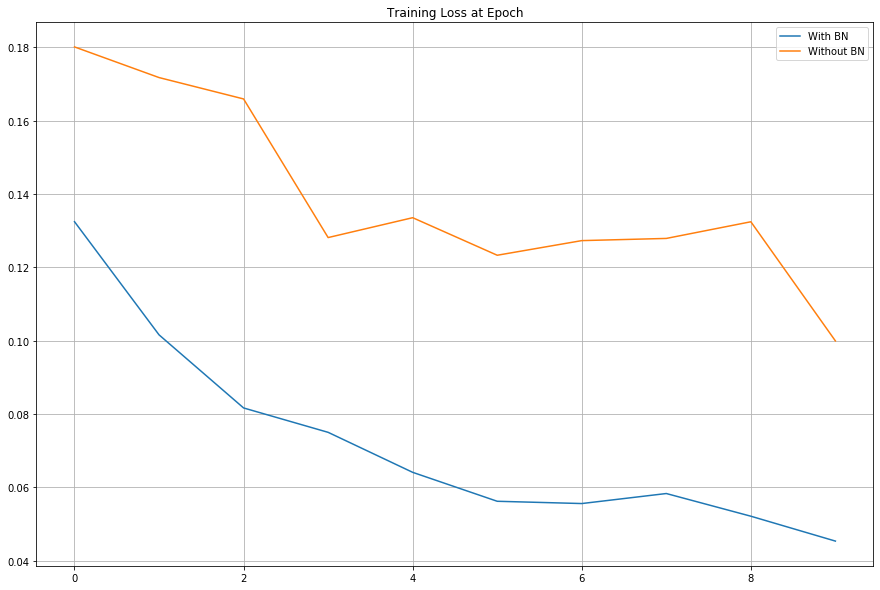

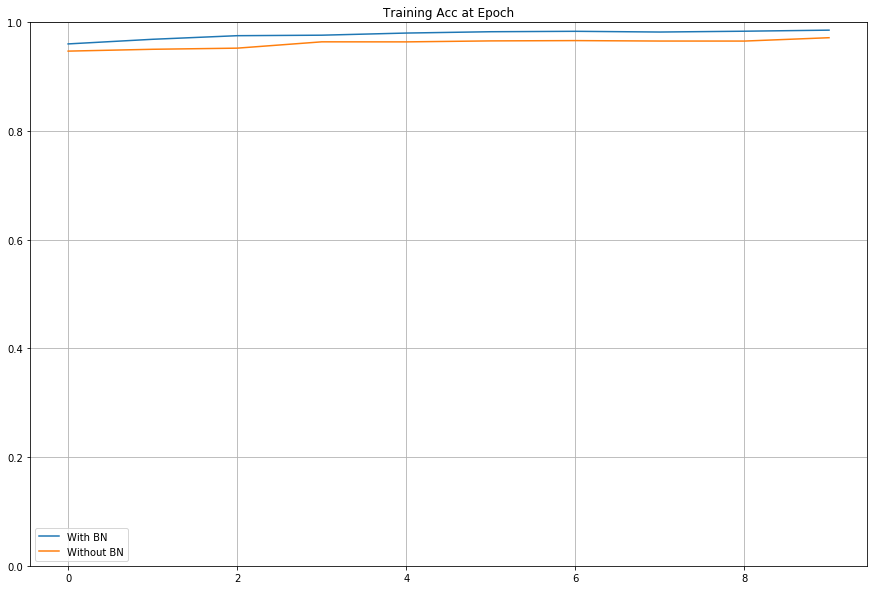

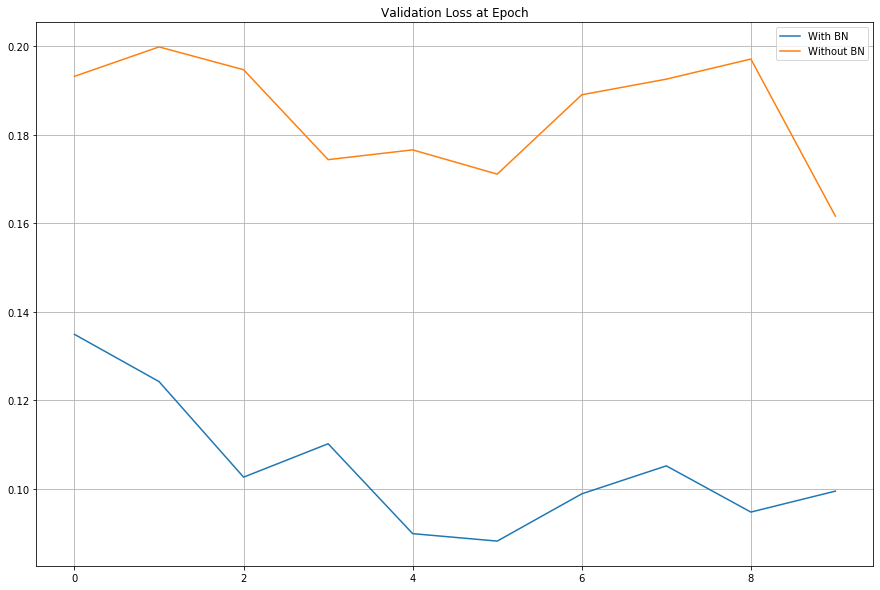

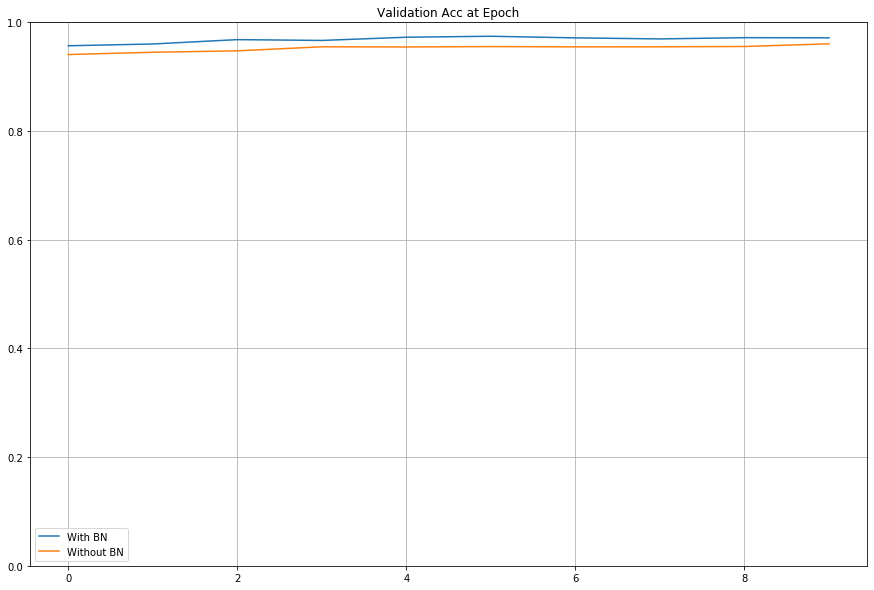

In [13]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')

다음 Tut에서도 BatchNorm에 대해 더 심도있게 다루어 보도록하겠습니다.